# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'
# floyd run --gpu --env tensorflow-1.0 --data R5KrjnANiKVhLWAkpXhNBe --mode jupyter

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

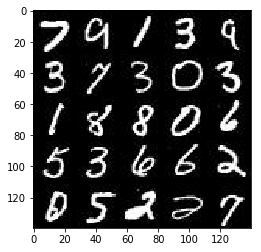

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

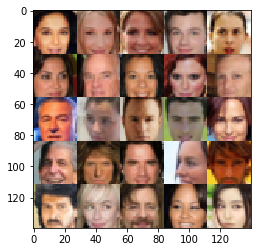

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='real_input')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='z_input')
    lr = tf.placeholder(tf.float32)
    # TODO: Implement Function

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        #input 28x28x3
        l1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.005))
        #dont use  batch normalization in first layer
        l1 = tf.maximum(alpha * l1, l1)
        # 14x14x64
        l2 = tf.layers.conv2d(l1, 256, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.005))
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(alpha * l2, l2)
        #7x7x128
        #l3 = tf.layers.conv2d(l2, 256, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        #l3 = tf.layers.batch_normalization(l3, training=True)
        #l3 = tf.maximum(alpha * l3, l3)
        #4x4x256
        #l4 = tf.layers.conv2d(l3, 512, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        #l4 = tf.layers.batch_normalization(l4, training=True)
        #l4 = tf.maximum(alpha * l4, l4)
        #2x2x512

        # Flatten it
        l5 = tf.reshape(l2, (-1, 7*7*256))
        logits = tf.layers.dense(l5, 1,kernel_initializer=tf.random_normal_initializer(stddev=0.005))
        #logits = tf.layers.dense(l5, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):

        f1 = tf.layers.dense(z, 7*7*265,kernel_initializer=tf.random_normal_initializer(stddev=0.005))

        l1 = tf.reshape(f1, (-1, 7, 7, 265))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        # 7x7x512
        
        l2 = tf.layers.conv2d_transpose(l1, 128, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.005))
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        # 14x14x128
        
        l3 = tf.layers.conv2d_transpose(l2, out_channel_dim, 5, strides=2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=0.005))
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        out = tf.tanh(l3)
        # 28x28x3 now

    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

   
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_updates = [opt for opt in  tf.get_collection(tf.GraphKeys.UPDATE_OPS) if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):   
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
        
    real_input, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(real_input, z_input,data_shape[3])
    
    d_opt , g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    n_img =25
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={real_input: 2*batch_images, z_input: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: batch_z, lr:learning_rate})

                if steps % 5== 0:
                    train_loss_d = d_loss.eval({z_input: batch_z, real_input: 2*batch_images})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, n_img, z_input, data_shape[3], data_image_mode)
                
        print("Traning Done!  ",
              "Discriminator Loss: {:.4f}.".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
        show_generator_output(sess, n_img, z_input, data_shape[3], data_image_mode)
    print('Cooldown')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 5... Discriminator Loss: 1.2542... Generator Loss: 0.9446
Epoch 1/2... Step 10... Discriminator Loss: 0.0391... Generator Loss: 7.1886
Epoch 1/2... Step 15... Discriminator Loss: 0.0019... Generator Loss: 11.3238
Epoch 1/2... Step 20... Discriminator Loss: 0.3525... Generator Loss: 2.4003
Epoch 1/2... Step 25... Discriminator Loss: 0.0743... Generator Loss: 3.2213
Epoch 1/2... Step 30... Discriminator Loss: 0.0377... Generator Loss: 4.0076
Epoch 1/2... Step 35... Discriminator Loss: 1.0919... Generator Loss: 2.0457
Epoch 1/2... Step 40... Discriminator Loss: 1.1483... Generator Loss: 3.0321
Epoch 1/2... Step 45... Discriminator Loss: 0.2372... Generator Loss: 4.4773
Epoch 1/2... Step 50... Discriminator Loss: 0.0256... Generator Loss: 4.5879
Epoch 1/2... Step 55... Discriminator Loss: 0.0272... Generator Loss: 4.1337
Epoch 1/2... Step 60... Discriminator Loss: 0.0311... Generator Loss: 4.1198
Epoch 1/2... Step 65... Discriminator Loss: 0.0128... Generator Loss: 5.5520

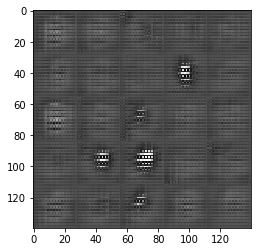

Epoch 1/2... Step 105... Discriminator Loss: 0.0785... Generator Loss: 4.0660
Epoch 1/2... Step 110... Discriminator Loss: 0.3301... Generator Loss: 1.9851
Epoch 1/2... Step 115... Discriminator Loss: 0.1250... Generator Loss: 4.4405
Epoch 1/2... Step 120... Discriminator Loss: 0.0974... Generator Loss: 6.4064
Epoch 1/2... Step 125... Discriminator Loss: 0.1221... Generator Loss: 7.0072
Epoch 1/2... Step 130... Discriminator Loss: 0.0478... Generator Loss: 9.8817
Epoch 1/2... Step 135... Discriminator Loss: 0.1454... Generator Loss: 7.3827
Epoch 1/2... Step 140... Discriminator Loss: 0.1045... Generator Loss: 5.3315
Epoch 1/2... Step 145... Discriminator Loss: 0.1898... Generator Loss: 3.3785
Epoch 1/2... Step 150... Discriminator Loss: 0.1097... Generator Loss: 4.0499
Epoch 1/2... Step 155... Discriminator Loss: 0.0447... Generator Loss: 4.6609
Epoch 1/2... Step 160... Discriminator Loss: 0.0457... Generator Loss: 5.0231
Epoch 1/2... Step 165... Discriminator Loss: 0.0317... Generator

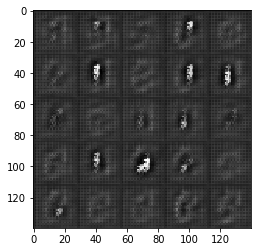

Epoch 1/2... Step 205... Discriminator Loss: 17.7616... Generator Loss: 0.0000
Epoch 1/2... Step 210... Discriminator Loss: 0.0705... Generator Loss: 4.6288
Epoch 1/2... Step 215... Discriminator Loss: 1.7523... Generator Loss: 9.9469
Epoch 1/2... Step 220... Discriminator Loss: 2.6609... Generator Loss: 2.1591
Epoch 1/2... Step 225... Discriminator Loss: 1.4032... Generator Loss: 4.8858
Epoch 1/2... Step 230... Discriminator Loss: 0.3303... Generator Loss: 8.6687
Epoch 1/2... Step 235... Discriminator Loss: 0.1960... Generator Loss: 4.2411
Epoch 1/2... Step 240... Discriminator Loss: 0.1879... Generator Loss: 3.0811
Epoch 1/2... Step 245... Discriminator Loss: 0.1617... Generator Loss: 6.9660
Epoch 1/2... Step 250... Discriminator Loss: 2.0385... Generator Loss: 0.7536
Epoch 1/2... Step 255... Discriminator Loss: 1.5386... Generator Loss: 1.5428
Epoch 1/2... Step 260... Discriminator Loss: 0.2659... Generator Loss: 10.6238
Epoch 1/2... Step 265... Discriminator Loss: 0.0633... Generat

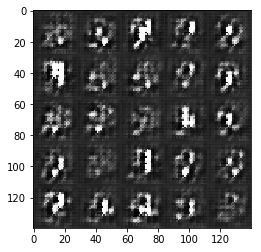

Epoch 1/2... Step 305... Discriminator Loss: 0.1103... Generator Loss: 3.2379
Epoch 1/2... Step 310... Discriminator Loss: 0.0600... Generator Loss: 4.1001
Epoch 1/2... Step 315... Discriminator Loss: 0.1229... Generator Loss: 7.1540
Epoch 1/2... Step 320... Discriminator Loss: 0.5188... Generator Loss: 1.3166
Epoch 1/2... Step 325... Discriminator Loss: 0.9065... Generator Loss: 7.6007
Epoch 1/2... Step 330... Discriminator Loss: 0.5305... Generator Loss: 1.8218
Epoch 1/2... Step 335... Discriminator Loss: 1.7930... Generator Loss: 0.2875
Epoch 1/2... Step 340... Discriminator Loss: 0.2172... Generator Loss: 4.9455
Epoch 1/2... Step 345... Discriminator Loss: 0.5152... Generator Loss: 5.1148
Epoch 1/2... Step 350... Discriminator Loss: 0.1044... Generator Loss: 4.1074
Epoch 1/2... Step 355... Discriminator Loss: 0.0601... Generator Loss: 4.9284
Epoch 1/2... Step 360... Discriminator Loss: 0.1139... Generator Loss: 2.8605
Epoch 1/2... Step 365... Discriminator Loss: 0.3957... Generator

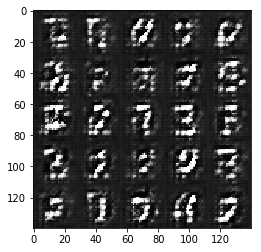

Epoch 1/2... Step 405... Discriminator Loss: 0.0900... Generator Loss: 4.3757
Epoch 1/2... Step 410... Discriminator Loss: 0.0611... Generator Loss: 4.3047
Epoch 1/2... Step 415... Discriminator Loss: 2.2121... Generator Loss: 7.5036
Epoch 1/2... Step 420... Discriminator Loss: 0.1710... Generator Loss: 2.7286
Epoch 1/2... Step 425... Discriminator Loss: 0.1139... Generator Loss: 3.1483
Epoch 1/2... Step 430... Discriminator Loss: 0.0744... Generator Loss: 3.8472
Epoch 1/2... Step 435... Discriminator Loss: 0.0883... Generator Loss: 3.2896
Epoch 1/2... Step 440... Discriminator Loss: 8.6415... Generator Loss: 14.4771
Epoch 1/2... Step 445... Discriminator Loss: 0.3096... Generator Loss: 2.0720
Epoch 1/2... Step 450... Discriminator Loss: 1.8455... Generator Loss: 0.2291
Epoch 1/2... Step 455... Discriminator Loss: 0.4230... Generator Loss: 1.7174
Epoch 1/2... Step 460... Discriminator Loss: 3.5431... Generator Loss: 0.0494
Epoch 1/2... Step 465... Discriminator Loss: 0.3126... Generato

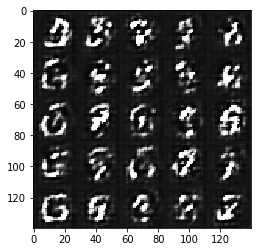

Epoch 1/2... Step 505... Discriminator Loss: 0.1430... Generator Loss: 3.8967
Epoch 1/2... Step 510... Discriminator Loss: 1.4473... Generator Loss: 0.7725
Epoch 1/2... Step 515... Discriminator Loss: 1.2542... Generator Loss: 0.5085
Epoch 1/2... Step 520... Discriminator Loss: 0.1567... Generator Loss: 2.5248
Epoch 1/2... Step 525... Discriminator Loss: 0.2181... Generator Loss: 2.1421
Epoch 1/2... Step 530... Discriminator Loss: 0.1022... Generator Loss: 2.7411
Epoch 1/2... Step 535... Discriminator Loss: 0.1160... Generator Loss: 2.7220
Epoch 1/2... Step 540... Discriminator Loss: 0.2667... Generator Loss: 1.6589
Epoch 1/2... Step 545... Discriminator Loss: 0.0638... Generator Loss: 4.1005
Epoch 1/2... Step 550... Discriminator Loss: 0.1646... Generator Loss: 2.1345
Epoch 1/2... Step 555... Discriminator Loss: 0.0618... Generator Loss: 3.5482
Epoch 1/2... Step 560... Discriminator Loss: 0.1182... Generator Loss: 4.0465
Epoch 1/2... Step 565... Discriminator Loss: 7.8046... Generator

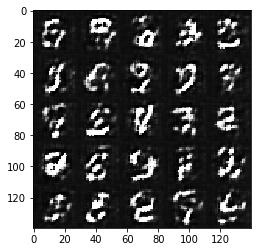

Epoch 1/2... Step 605... Discriminator Loss: 0.5863... Generator Loss: 1.5786
Epoch 1/2... Step 610... Discriminator Loss: 1.1096... Generator Loss: 6.9136
Epoch 1/2... Step 615... Discriminator Loss: 1.2471... Generator Loss: 4.9558
Epoch 1/2... Step 620... Discriminator Loss: 0.3276... Generator Loss: 1.8170
Epoch 1/2... Step 625... Discriminator Loss: 0.1569... Generator Loss: 2.9924
Epoch 1/2... Step 630... Discriminator Loss: 6.1453... Generator Loss: 0.0047
Epoch 1/2... Step 635... Discriminator Loss: 0.9834... Generator Loss: 0.8454
Epoch 1/2... Step 640... Discriminator Loss: 0.3404... Generator Loss: 1.5726
Epoch 1/2... Step 645... Discriminator Loss: 3.4060... Generator Loss: 8.4058
Epoch 1/2... Step 650... Discriminator Loss: 0.4622... Generator Loss: 3.9668
Epoch 1/2... Step 655... Discriminator Loss: 0.3497... Generator Loss: 2.2464
Epoch 1/2... Step 660... Discriminator Loss: 2.9031... Generator Loss: 8.3132
Epoch 1/2... Step 665... Discriminator Loss: 0.2541... Generator

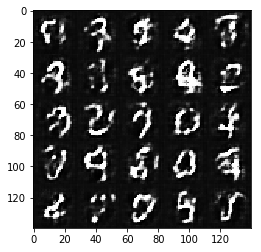

Epoch 1/2... Step 705... Discriminator Loss: 0.4983... Generator Loss: 1.2455
Epoch 1/2... Step 710... Discriminator Loss: 4.4292... Generator Loss: 8.6722
Epoch 1/2... Step 715... Discriminator Loss: 0.5186... Generator Loss: 2.5143
Epoch 1/2... Step 720... Discriminator Loss: 2.2220... Generator Loss: 0.1782
Epoch 1/2... Step 725... Discriminator Loss: 0.3641... Generator Loss: 1.7709
Epoch 1/2... Step 730... Discriminator Loss: 1.3205... Generator Loss: 0.4006
Epoch 1/2... Step 735... Discriminator Loss: 0.5124... Generator Loss: 1.3418
Epoch 1/2... Step 740... Discriminator Loss: 0.3663... Generator Loss: 2.5118
Epoch 1/2... Step 745... Discriminator Loss: 2.9643... Generator Loss: 7.0863
Epoch 1/2... Step 750... Discriminator Loss: 0.4375... Generator Loss: 1.8336
Epoch 1/2... Step 755... Discriminator Loss: 0.5150... Generator Loss: 3.2353
Epoch 1/2... Step 760... Discriminator Loss: 0.4317... Generator Loss: 3.7078
Epoch 1/2... Step 765... Discriminator Loss: 0.5543... Generator

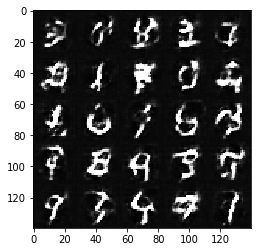

Epoch 1/2... Step 805... Discriminator Loss: 2.7578... Generator Loss: 6.3636
Epoch 1/2... Step 810... Discriminator Loss: 0.9705... Generator Loss: 4.0019
Epoch 1/2... Step 815... Discriminator Loss: 0.9921... Generator Loss: 0.7530
Epoch 1/2... Step 820... Discriminator Loss: 0.8198... Generator Loss: 3.3899
Epoch 1/2... Step 825... Discriminator Loss: 2.3459... Generator Loss: 6.4740
Epoch 1/2... Step 830... Discriminator Loss: 0.5109... Generator Loss: 3.0901
Epoch 1/2... Step 835... Discriminator Loss: 1.6949... Generator Loss: 0.2755
Epoch 1/2... Step 840... Discriminator Loss: 0.3699... Generator Loss: 2.2865
Epoch 1/2... Step 845... Discriminator Loss: 1.5371... Generator Loss: 0.3998
Epoch 1/2... Step 850... Discriminator Loss: 0.5925... Generator Loss: 2.9971
Epoch 1/2... Step 855... Discriminator Loss: 1.0858... Generator Loss: 0.4885
Epoch 1/2... Step 860... Discriminator Loss: 0.7488... Generator Loss: 3.7037
Epoch 1/2... Step 865... Discriminator Loss: 0.4328... Generator

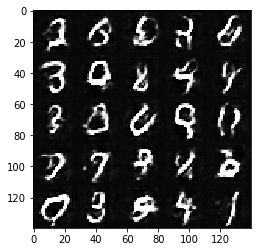

Epoch 1/2... Step 905... Discriminator Loss: 0.7062... Generator Loss: 2.8070
Epoch 1/2... Step 910... Discriminator Loss: 1.1074... Generator Loss: 3.9000
Epoch 1/2... Step 915... Discriminator Loss: 0.5517... Generator Loss: 2.0976
Epoch 1/2... Step 920... Discriminator Loss: 0.3810... Generator Loss: 1.4682
Epoch 1/2... Step 925... Discriminator Loss: 2.4550... Generator Loss: 0.1137
Epoch 1/2... Step 930... Discriminator Loss: 0.7453... Generator Loss: 0.8305
Epoch 1/2... Step 935... Discriminator Loss: 1.0029... Generator Loss: 3.0336
Epoch 2/2... Step 5... Discriminator Loss: 1.7521... Generator Loss: 0.2462
Epoch 2/2... Step 10... Discriminator Loss: 0.7027... Generator Loss: 1.0308
Epoch 2/2... Step 15... Discriminator Loss: 0.5408... Generator Loss: 1.4168
Epoch 2/2... Step 20... Discriminator Loss: 2.5086... Generator Loss: 6.0815
Epoch 2/2... Step 25... Discriminator Loss: 0.6105... Generator Loss: 1.2353
Epoch 2/2... Step 30... Discriminator Loss: 0.5315... Generator Loss: 

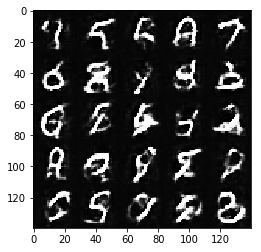

Epoch 2/2... Step 105... Discriminator Loss: 1.1835... Generator Loss: 3.6643
Epoch 2/2... Step 110... Discriminator Loss: 0.6526... Generator Loss: 2.6951
Epoch 2/2... Step 115... Discriminator Loss: 0.7516... Generator Loss: 0.9524
Epoch 2/2... Step 120... Discriminator Loss: 1.4839... Generator Loss: 4.4172
Epoch 2/2... Step 125... Discriminator Loss: 0.5341... Generator Loss: 1.5150
Epoch 2/2... Step 130... Discriminator Loss: 2.0666... Generator Loss: 0.1943
Epoch 2/2... Step 135... Discriminator Loss: 0.5811... Generator Loss: 1.8437
Epoch 2/2... Step 140... Discriminator Loss: 0.4967... Generator Loss: 1.3343
Epoch 2/2... Step 145... Discriminator Loss: 0.4860... Generator Loss: 1.6963
Epoch 2/2... Step 150... Discriminator Loss: 2.2646... Generator Loss: 0.1499
Epoch 2/2... Step 155... Discriminator Loss: 1.4137... Generator Loss: 0.4808
Epoch 2/2... Step 160... Discriminator Loss: 0.8909... Generator Loss: 2.5561
Epoch 2/2... Step 165... Discriminator Loss: 0.6152... Generator

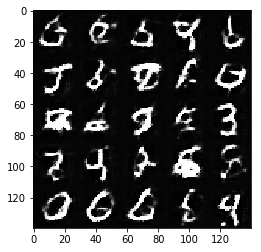

Epoch 2/2... Step 205... Discriminator Loss: 0.5676... Generator Loss: 1.7173
Epoch 2/2... Step 210... Discriminator Loss: 0.5917... Generator Loss: 1.0074
Epoch 2/2... Step 215... Discriminator Loss: 3.1411... Generator Loss: 5.9697
Epoch 2/2... Step 220... Discriminator Loss: 2.3628... Generator Loss: 5.0824
Epoch 2/2... Step 225... Discriminator Loss: 0.6487... Generator Loss: 1.0317
Epoch 2/2... Step 230... Discriminator Loss: 1.1239... Generator Loss: 0.5318
Epoch 2/2... Step 235... Discriminator Loss: 0.6125... Generator Loss: 1.6104
Epoch 2/2... Step 240... Discriminator Loss: 1.3881... Generator Loss: 3.5069
Epoch 2/2... Step 245... Discriminator Loss: 1.4609... Generator Loss: 0.4480
Epoch 2/2... Step 250... Discriminator Loss: 0.9235... Generator Loss: 0.6999
Epoch 2/2... Step 255... Discriminator Loss: 0.7791... Generator Loss: 0.8307
Epoch 2/2... Step 260... Discriminator Loss: 1.8413... Generator Loss: 4.5186
Epoch 2/2... Step 265... Discriminator Loss: 0.7817... Generator

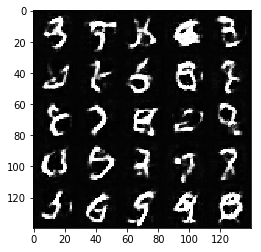

Epoch 2/2... Step 305... Discriminator Loss: 0.5308... Generator Loss: 2.6979
Epoch 2/2... Step 310... Discriminator Loss: 1.4794... Generator Loss: 0.3419
Epoch 2/2... Step 315... Discriminator Loss: 0.4922... Generator Loss: 2.4868
Epoch 2/2... Step 320... Discriminator Loss: 1.4514... Generator Loss: 0.3657
Epoch 2/2... Step 325... Discriminator Loss: 0.3209... Generator Loss: 1.9872
Epoch 2/2... Step 330... Discriminator Loss: 0.4389... Generator Loss: 1.5994
Epoch 2/2... Step 335... Discriminator Loss: 0.4196... Generator Loss: 1.8771
Epoch 2/2... Step 340... Discriminator Loss: 2.2213... Generator Loss: 0.1694
Epoch 2/2... Step 345... Discriminator Loss: 0.5741... Generator Loss: 2.5730
Epoch 2/2... Step 350... Discriminator Loss: 1.2658... Generator Loss: 0.4328
Epoch 2/2... Step 355... Discriminator Loss: 0.7617... Generator Loss: 0.9987
Epoch 2/2... Step 360... Discriminator Loss: 0.5599... Generator Loss: 2.1803
Epoch 2/2... Step 365... Discriminator Loss: 0.8676... Generator

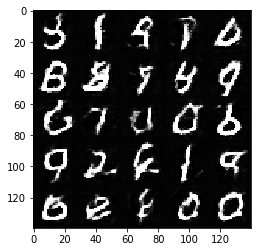

Epoch 2/2... Step 405... Discriminator Loss: 0.8330... Generator Loss: 4.6031
Epoch 2/2... Step 410... Discriminator Loss: 0.5206... Generator Loss: 3.0043
Epoch 2/2... Step 415... Discriminator Loss: 0.8101... Generator Loss: 0.7815
Epoch 2/2... Step 420... Discriminator Loss: 1.0541... Generator Loss: 0.5973
Epoch 2/2... Step 425... Discriminator Loss: 0.3945... Generator Loss: 2.0935
Epoch 2/2... Step 430... Discriminator Loss: 1.1665... Generator Loss: 0.5999
Epoch 2/2... Step 435... Discriminator Loss: 0.5581... Generator Loss: 2.8977
Epoch 2/2... Step 440... Discriminator Loss: 0.5650... Generator Loss: 1.9150
Epoch 2/2... Step 445... Discriminator Loss: 0.3353... Generator Loss: 1.8402
Epoch 2/2... Step 450... Discriminator Loss: 1.1911... Generator Loss: 0.4753
Epoch 2/2... Step 455... Discriminator Loss: 0.7110... Generator Loss: 0.8595
Epoch 2/2... Step 460... Discriminator Loss: 0.1800... Generator Loss: 3.3928
Epoch 2/2... Step 465... Discriminator Loss: 0.7946... Generator

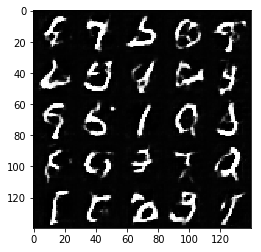

Epoch 2/2... Step 505... Discriminator Loss: 1.6763... Generator Loss: 0.3036
Epoch 2/2... Step 510... Discriminator Loss: 2.5221... Generator Loss: 0.1881
Epoch 2/2... Step 515... Discriminator Loss: 0.8066... Generator Loss: 0.8900
Epoch 2/2... Step 520... Discriminator Loss: 0.3768... Generator Loss: 2.8611
Epoch 2/2... Step 525... Discriminator Loss: 0.6872... Generator Loss: 1.4944
Epoch 2/2... Step 530... Discriminator Loss: 0.5702... Generator Loss: 1.1535
Epoch 2/2... Step 535... Discriminator Loss: 0.3101... Generator Loss: 2.4910
Epoch 2/2... Step 540... Discriminator Loss: 0.6165... Generator Loss: 1.0691
Epoch 2/2... Step 545... Discriminator Loss: 0.3327... Generator Loss: 1.5634
Epoch 2/2... Step 550... Discriminator Loss: 1.1844... Generator Loss: 0.5259
Epoch 2/2... Step 555... Discriminator Loss: 1.2788... Generator Loss: 3.2670
Epoch 2/2... Step 560... Discriminator Loss: 2.1633... Generator Loss: 0.2142
Epoch 2/2... Step 565... Discriminator Loss: 0.7643... Generator

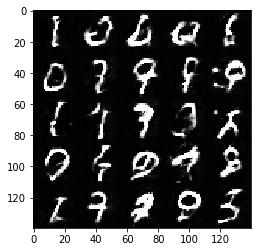

Epoch 2/2... Step 605... Discriminator Loss: 0.9024... Generator Loss: 1.0204
Epoch 2/2... Step 610... Discriminator Loss: 0.6249... Generator Loss: 1.1128
Epoch 2/2... Step 615... Discriminator Loss: 2.1144... Generator Loss: 0.1789
Epoch 2/2... Step 620... Discriminator Loss: 1.1732... Generator Loss: 0.5846
Epoch 2/2... Step 625... Discriminator Loss: 0.6174... Generator Loss: 1.1571
Epoch 2/2... Step 630... Discriminator Loss: 0.4540... Generator Loss: 2.5863
Epoch 2/2... Step 635... Discriminator Loss: 0.7798... Generator Loss: 1.0551
Epoch 2/2... Step 640... Discriminator Loss: 0.5717... Generator Loss: 1.1472
Epoch 2/2... Step 645... Discriminator Loss: 0.9301... Generator Loss: 0.7263
Epoch 2/2... Step 650... Discriminator Loss: 0.5767... Generator Loss: 1.5202
Epoch 2/2... Step 655... Discriminator Loss: 0.2997... Generator Loss: 3.5167
Epoch 2/2... Step 660... Discriminator Loss: 1.0750... Generator Loss: 3.4487
Epoch 2/2... Step 665... Discriminator Loss: 2.1062... Generator

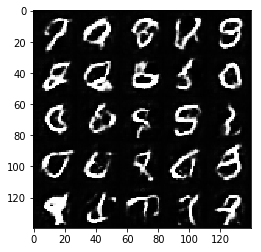

Epoch 2/2... Step 705... Discriminator Loss: 0.7122... Generator Loss: 1.9448
Epoch 2/2... Step 710... Discriminator Loss: 1.6262... Generator Loss: 0.3094
Epoch 2/2... Step 715... Discriminator Loss: 1.3508... Generator Loss: 3.9300
Epoch 2/2... Step 720... Discriminator Loss: 0.5734... Generator Loss: 1.6149
Epoch 2/2... Step 725... Discriminator Loss: 0.9081... Generator Loss: 2.7225
Epoch 2/2... Step 730... Discriminator Loss: 0.8302... Generator Loss: 0.8356
Epoch 2/2... Step 735... Discriminator Loss: 1.5968... Generator Loss: 0.3678
Epoch 2/2... Step 740... Discriminator Loss: 0.8480... Generator Loss: 0.7894
Epoch 2/2... Step 745... Discriminator Loss: 1.2084... Generator Loss: 3.2621
Epoch 2/2... Step 750... Discriminator Loss: 1.2703... Generator Loss: 0.4728
Epoch 2/2... Step 755... Discriminator Loss: 0.6685... Generator Loss: 1.1217
Epoch 2/2... Step 760... Discriminator Loss: 0.5393... Generator Loss: 2.2468
Epoch 2/2... Step 765... Discriminator Loss: 1.9370... Generator

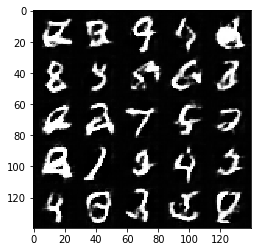

Epoch 2/2... Step 805... Discriminator Loss: 1.0018... Generator Loss: 0.7429
Epoch 2/2... Step 810... Discriminator Loss: 1.1186... Generator Loss: 0.7783
Epoch 2/2... Step 815... Discriminator Loss: 1.5707... Generator Loss: 0.3563
Epoch 2/2... Step 820... Discriminator Loss: 0.5952... Generator Loss: 2.1874
Epoch 2/2... Step 825... Discriminator Loss: 0.4145... Generator Loss: 2.3189
Epoch 2/2... Step 830... Discriminator Loss: 0.6759... Generator Loss: 2.1476
Epoch 2/2... Step 835... Discriminator Loss: 1.0117... Generator Loss: 0.6623
Epoch 2/2... Step 840... Discriminator Loss: 0.3987... Generator Loss: 2.1500
Epoch 2/2... Step 845... Discriminator Loss: 2.0952... Generator Loss: 0.2758
Epoch 2/2... Step 850... Discriminator Loss: 0.7464... Generator Loss: 1.0696
Epoch 2/2... Step 855... Discriminator Loss: 1.8137... Generator Loss: 4.9822
Epoch 2/2... Step 860... Discriminator Loss: 1.3513... Generator Loss: 0.6001
Epoch 2/2... Step 865... Discriminator Loss: 0.5264... Generator

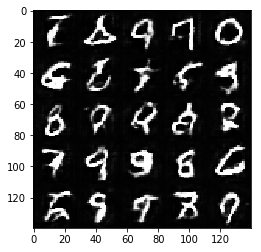

Epoch 2/2... Step 905... Discriminator Loss: 1.0743... Generator Loss: 0.6205
Epoch 2/2... Step 910... Discriminator Loss: 0.6154... Generator Loss: 1.3940
Epoch 2/2... Step 915... Discriminator Loss: 0.7543... Generator Loss: 0.9930
Epoch 2/2... Step 920... Discriminator Loss: 0.4058... Generator Loss: 2.3735
Epoch 2/2... Step 925... Discriminator Loss: 0.9741... Generator Loss: 0.6556
Epoch 2/2... Step 930... Discriminator Loss: 0.3533... Generator Loss: 2.1699
Epoch 2/2... Step 935... Discriminator Loss: 0.9742... Generator Loss: 2.7287
Traning Done!   Discriminator Loss: 0.9742. Generator Loss: 2.7287


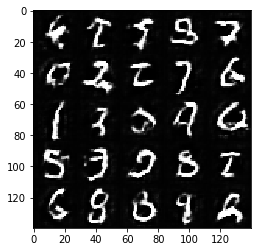

Cooldown


In [13]:
batch_size = 64
z_dim = 100#512
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 5... Discriminator Loss: 0.1039... Generator Loss: 4.5642
Epoch 1/1... Step 10... Discriminator Loss: 10.2722... Generator Loss: 12.2688
Epoch 1/1... Step 15... Discriminator Loss: 0.0793... Generator Loss: 3.4867
Epoch 1/1... Step 20... Discriminator Loss: 0.2074... Generator Loss: 3.0182
Epoch 1/1... Step 25... Discriminator Loss: 0.0593... Generator Loss: 4.7346
Epoch 1/1... Step 30... Discriminator Loss: 1.3730... Generator Loss: 1.0656
Epoch 1/1... Step 35... Discriminator Loss: 4.2829... Generator Loss: 14.9607
Epoch 1/1... Step 40... Discriminator Loss: 0.1339... Generator Loss: 3.6502
Epoch 1/1... Step 45... Discriminator Loss: 2.5263... Generator Loss: 0.7963
Epoch 1/1... Step 50... Discriminator Loss: 0.3003... Generator Loss: 4.7520
Epoch 1/1... Step 55... Discriminator Loss: 4.8187... Generator Loss: 10.7075
Epoch 1/1... Step 60... Discriminator Loss: 0.1251... Generator Loss: 5.8670
Epoch 1/1... Step 65... Discriminator Loss: 1.1094... Generator Loss: 0.7

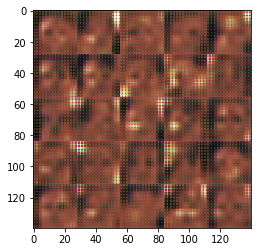

Epoch 1/1... Step 105... Discriminator Loss: 0.4649... Generator Loss: 3.9228
Epoch 1/1... Step 110... Discriminator Loss: 1.6020... Generator Loss: 1.3949
Epoch 1/1... Step 115... Discriminator Loss: 3.4901... Generator Loss: 0.1065
Epoch 1/1... Step 120... Discriminator Loss: 1.4614... Generator Loss: 2.2627
Epoch 1/1... Step 125... Discriminator Loss: 1.1040... Generator Loss: 1.0028
Epoch 1/1... Step 130... Discriminator Loss: 1.6358... Generator Loss: 1.1418
Epoch 1/1... Step 135... Discriminator Loss: 3.2519... Generator Loss: 0.4724
Epoch 1/1... Step 140... Discriminator Loss: 2.4269... Generator Loss: 0.4245
Epoch 1/1... Step 145... Discriminator Loss: 1.5197... Generator Loss: 0.8077
Epoch 1/1... Step 150... Discriminator Loss: 1.6872... Generator Loss: 1.9366
Epoch 1/1... Step 155... Discriminator Loss: 1.5545... Generator Loss: 0.5896
Epoch 1/1... Step 160... Discriminator Loss: 1.5533... Generator Loss: 2.4587
Epoch 1/1... Step 165... Discriminator Loss: 1.0614... Generator

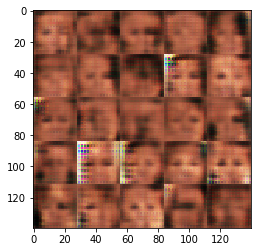

Epoch 1/1... Step 205... Discriminator Loss: 1.0363... Generator Loss: 1.6765
Epoch 1/1... Step 210... Discriminator Loss: 1.4759... Generator Loss: 0.7581
Epoch 1/1... Step 215... Discriminator Loss: 1.1251... Generator Loss: 1.4017
Epoch 1/1... Step 220... Discriminator Loss: 1.3838... Generator Loss: 0.7363
Epoch 1/1... Step 225... Discriminator Loss: 1.8007... Generator Loss: 1.4233
Epoch 1/1... Step 230... Discriminator Loss: 2.6344... Generator Loss: 2.7447
Epoch 1/1... Step 235... Discriminator Loss: 1.2261... Generator Loss: 1.0481
Epoch 1/1... Step 240... Discriminator Loss: 1.4150... Generator Loss: 0.4982
Epoch 1/1... Step 245... Discriminator Loss: 1.2788... Generator Loss: 1.5657
Epoch 1/1... Step 250... Discriminator Loss: 1.5123... Generator Loss: 0.6460
Epoch 1/1... Step 255... Discriminator Loss: 2.3136... Generator Loss: 0.2093
Epoch 1/1... Step 260... Discriminator Loss: 2.1324... Generator Loss: 0.2210
Epoch 1/1... Step 265... Discriminator Loss: 1.6271... Generator

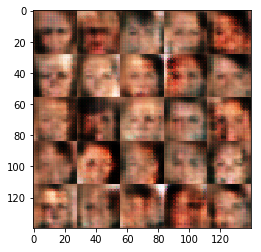

Epoch 1/1... Step 305... Discriminator Loss: 1.4652... Generator Loss: 1.2639
Epoch 1/1... Step 310... Discriminator Loss: 1.3054... Generator Loss: 1.2535
Epoch 1/1... Step 315... Discriminator Loss: 2.4643... Generator Loss: 0.1373
Epoch 1/1... Step 320... Discriminator Loss: 1.3198... Generator Loss: 0.8346
Epoch 1/1... Step 325... Discriminator Loss: 1.2123... Generator Loss: 0.8621
Epoch 1/1... Step 330... Discriminator Loss: 1.4932... Generator Loss: 1.0996
Epoch 1/1... Step 335... Discriminator Loss: 1.3021... Generator Loss: 0.6603
Epoch 1/1... Step 340... Discriminator Loss: 1.1183... Generator Loss: 0.8210
Epoch 1/1... Step 345... Discriminator Loss: 1.3150... Generator Loss: 0.9149
Epoch 1/1... Step 350... Discriminator Loss: 1.3240... Generator Loss: 0.9744
Epoch 1/1... Step 355... Discriminator Loss: 1.9800... Generator Loss: 0.2257
Epoch 1/1... Step 360... Discriminator Loss: 1.4272... Generator Loss: 1.0224
Epoch 1/1... Step 365... Discriminator Loss: 2.0840... Generator

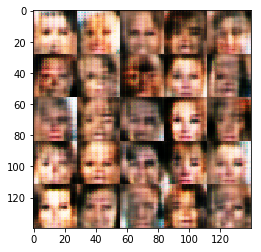

Epoch 1/1... Step 405... Discriminator Loss: 1.2660... Generator Loss: 0.7538
Epoch 1/1... Step 410... Discriminator Loss: 1.3737... Generator Loss: 1.1997
Epoch 1/1... Step 415... Discriminator Loss: 1.1253... Generator Loss: 1.3185
Epoch 1/1... Step 420... Discriminator Loss: 1.0515... Generator Loss: 1.0817
Epoch 1/1... Step 425... Discriminator Loss: 1.6645... Generator Loss: 1.4375
Epoch 1/1... Step 430... Discriminator Loss: 1.9879... Generator Loss: 0.2712
Epoch 1/1... Step 435... Discriminator Loss: 1.3156... Generator Loss: 0.7997
Epoch 1/1... Step 440... Discriminator Loss: 1.5368... Generator Loss: 0.5502
Epoch 1/1... Step 445... Discriminator Loss: 1.1747... Generator Loss: 1.1734
Epoch 1/1... Step 450... Discriminator Loss: 2.1016... Generator Loss: 2.7364
Epoch 1/1... Step 455... Discriminator Loss: 1.6253... Generator Loss: 0.9908
Epoch 1/1... Step 460... Discriminator Loss: 1.2287... Generator Loss: 0.6681
Epoch 1/1... Step 465... Discriminator Loss: 1.9311... Generator

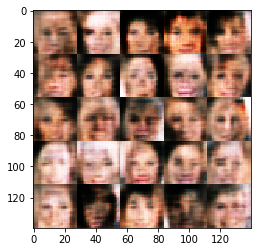

Epoch 1/1... Step 505... Discriminator Loss: 1.2349... Generator Loss: 0.6185
Epoch 1/1... Step 510... Discriminator Loss: 1.5096... Generator Loss: 1.2644
Epoch 1/1... Step 515... Discriminator Loss: 1.3436... Generator Loss: 1.5409
Epoch 1/1... Step 520... Discriminator Loss: 1.3723... Generator Loss: 0.5975
Epoch 1/1... Step 525... Discriminator Loss: 1.3247... Generator Loss: 0.7049
Epoch 1/1... Step 530... Discriminator Loss: 1.4018... Generator Loss: 1.0124
Epoch 1/1... Step 535... Discriminator Loss: 1.2537... Generator Loss: 0.7579
Epoch 1/1... Step 540... Discriminator Loss: 1.3080... Generator Loss: 0.7654
Epoch 1/1... Step 545... Discriminator Loss: 1.3641... Generator Loss: 0.5222
Epoch 1/1... Step 550... Discriminator Loss: 1.2981... Generator Loss: 0.9906
Epoch 1/1... Step 555... Discriminator Loss: 1.4217... Generator Loss: 1.3922
Epoch 1/1... Step 560... Discriminator Loss: 2.1082... Generator Loss: 2.3805
Epoch 1/1... Step 565... Discriminator Loss: 1.3323... Generator

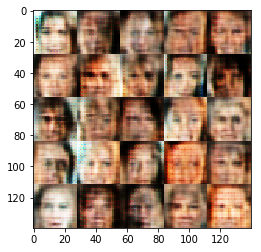

Epoch 1/1... Step 605... Discriminator Loss: 0.9756... Generator Loss: 1.0094
Epoch 1/1... Step 610... Discriminator Loss: 1.4692... Generator Loss: 1.6424
Epoch 1/1... Step 615... Discriminator Loss: 1.4816... Generator Loss: 0.4893
Epoch 1/1... Step 620... Discriminator Loss: 1.2483... Generator Loss: 0.8307
Epoch 1/1... Step 625... Discriminator Loss: 1.3278... Generator Loss: 1.3108
Epoch 1/1... Step 630... Discriminator Loss: 1.4133... Generator Loss: 0.7610
Epoch 1/1... Step 635... Discriminator Loss: 1.2387... Generator Loss: 0.6781
Epoch 1/1... Step 640... Discriminator Loss: 1.0118... Generator Loss: 0.8697
Epoch 1/1... Step 645... Discriminator Loss: 1.3504... Generator Loss: 0.7287
Epoch 1/1... Step 650... Discriminator Loss: 1.3437... Generator Loss: 0.6733
Epoch 1/1... Step 655... Discriminator Loss: 1.5229... Generator Loss: 0.7406
Epoch 1/1... Step 660... Discriminator Loss: 1.2568... Generator Loss: 1.2317
Epoch 1/1... Step 665... Discriminator Loss: 1.3954... Generator

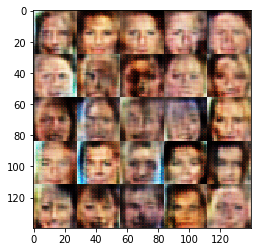

Epoch 1/1... Step 705... Discriminator Loss: 1.7804... Generator Loss: 0.3128
Epoch 1/1... Step 710... Discriminator Loss: 1.8507... Generator Loss: 1.9251
Epoch 1/1... Step 715... Discriminator Loss: 1.3638... Generator Loss: 1.0767
Epoch 1/1... Step 720... Discriminator Loss: 1.3145... Generator Loss: 0.9415
Epoch 1/1... Step 725... Discriminator Loss: 1.5601... Generator Loss: 0.4747
Epoch 1/1... Step 730... Discriminator Loss: 1.3309... Generator Loss: 0.5096
Epoch 1/1... Step 735... Discriminator Loss: 1.3529... Generator Loss: 0.8468
Epoch 1/1... Step 740... Discriminator Loss: 1.2046... Generator Loss: 1.0013
Epoch 1/1... Step 745... Discriminator Loss: 2.5052... Generator Loss: 0.1500
Epoch 1/1... Step 750... Discriminator Loss: 1.1473... Generator Loss: 0.8036
Epoch 1/1... Step 755... Discriminator Loss: 1.3431... Generator Loss: 0.8455
Epoch 1/1... Step 760... Discriminator Loss: 1.3531... Generator Loss: 0.6819
Epoch 1/1... Step 765... Discriminator Loss: 1.5439... Generator

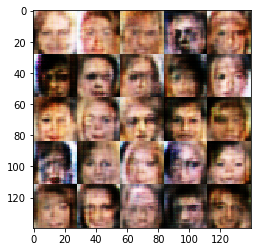

Epoch 1/1... Step 805... Discriminator Loss: 1.5995... Generator Loss: 0.3714
Epoch 1/1... Step 810... Discriminator Loss: 1.3521... Generator Loss: 0.5276
Epoch 1/1... Step 815... Discriminator Loss: 1.4447... Generator Loss: 0.8513
Epoch 1/1... Step 820... Discriminator Loss: 1.4306... Generator Loss: 1.1532
Epoch 1/1... Step 825... Discriminator Loss: 0.9202... Generator Loss: 1.4066
Epoch 1/1... Step 830... Discriminator Loss: 1.8021... Generator Loss: 0.7487
Epoch 1/1... Step 835... Discriminator Loss: 1.3000... Generator Loss: 0.8555
Epoch 1/1... Step 840... Discriminator Loss: 1.2738... Generator Loss: 1.0296
Epoch 1/1... Step 845... Discriminator Loss: 1.4488... Generator Loss: 0.7238
Epoch 1/1... Step 850... Discriminator Loss: 1.2039... Generator Loss: 0.8041
Epoch 1/1... Step 855... Discriminator Loss: 1.3752... Generator Loss: 1.1696
Epoch 1/1... Step 860... Discriminator Loss: 1.3045... Generator Loss: 0.8638
Epoch 1/1... Step 865... Discriminator Loss: 1.4133... Generator

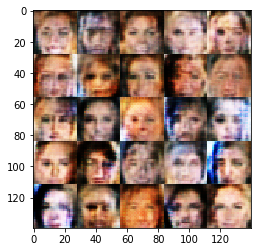

Epoch 1/1... Step 905... Discriminator Loss: 1.6292... Generator Loss: 0.4361
Epoch 1/1... Step 910... Discriminator Loss: 1.3870... Generator Loss: 0.6911
Epoch 1/1... Step 915... Discriminator Loss: 1.4743... Generator Loss: 0.5411
Epoch 1/1... Step 920... Discriminator Loss: 1.4798... Generator Loss: 0.6821
Epoch 1/1... Step 925... Discriminator Loss: 1.2279... Generator Loss: 0.8805
Epoch 1/1... Step 930... Discriminator Loss: 1.1251... Generator Loss: 0.8503
Epoch 1/1... Step 935... Discriminator Loss: 1.4538... Generator Loss: 0.5361
Epoch 1/1... Step 940... Discriminator Loss: 1.7386... Generator Loss: 0.4612
Epoch 1/1... Step 945... Discriminator Loss: 1.3264... Generator Loss: 0.6274
Epoch 1/1... Step 950... Discriminator Loss: 1.5690... Generator Loss: 0.3901
Epoch 1/1... Step 955... Discriminator Loss: 1.0998... Generator Loss: 0.6930
Epoch 1/1... Step 960... Discriminator Loss: 1.2875... Generator Loss: 0.7348
Epoch 1/1... Step 965... Discriminator Loss: 1.3536... Generator

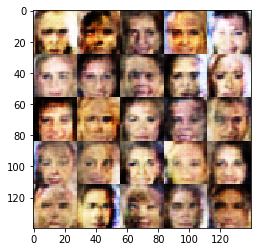

Epoch 1/1... Step 1005... Discriminator Loss: 1.1778... Generator Loss: 0.8095
Epoch 1/1... Step 1010... Discriminator Loss: 1.4362... Generator Loss: 0.5722
Epoch 1/1... Step 1015... Discriminator Loss: 1.2614... Generator Loss: 0.6399
Epoch 1/1... Step 1020... Discriminator Loss: 1.2814... Generator Loss: 0.9994
Epoch 1/1... Step 1025... Discriminator Loss: 1.3178... Generator Loss: 0.7833
Epoch 1/1... Step 1030... Discriminator Loss: 1.3881... Generator Loss: 0.9073
Epoch 1/1... Step 1035... Discriminator Loss: 1.1264... Generator Loss: 0.7726
Epoch 1/1... Step 1040... Discriminator Loss: 1.1222... Generator Loss: 0.6726
Epoch 1/1... Step 1045... Discriminator Loss: 1.2374... Generator Loss: 0.9385
Epoch 1/1... Step 1050... Discriminator Loss: 1.4957... Generator Loss: 0.3919
Epoch 1/1... Step 1055... Discriminator Loss: 1.4743... Generator Loss: 0.9363
Epoch 1/1... Step 1060... Discriminator Loss: 1.3143... Generator Loss: 0.5994
Epoch 1/1... Step 1065... Discriminator Loss: 1.4819

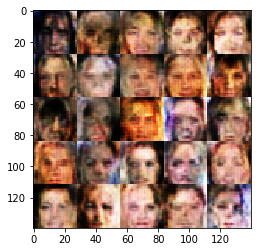

Epoch 1/1... Step 1105... Discriminator Loss: 2.0021... Generator Loss: 0.2604
Epoch 1/1... Step 1110... Discriminator Loss: 1.4404... Generator Loss: 0.5337
Epoch 1/1... Step 1115... Discriminator Loss: 1.1985... Generator Loss: 0.8957
Epoch 1/1... Step 1120... Discriminator Loss: 1.4115... Generator Loss: 0.5225
Epoch 1/1... Step 1125... Discriminator Loss: 1.3599... Generator Loss: 0.4212
Epoch 1/1... Step 1130... Discriminator Loss: 1.5568... Generator Loss: 1.5882
Epoch 1/1... Step 1135... Discriminator Loss: 1.2933... Generator Loss: 0.7673
Epoch 1/1... Step 1140... Discriminator Loss: 1.5682... Generator Loss: 1.1256
Epoch 1/1... Step 1145... Discriminator Loss: 1.1944... Generator Loss: 0.6889
Epoch 1/1... Step 1150... Discriminator Loss: 1.2040... Generator Loss: 0.8822
Epoch 1/1... Step 1155... Discriminator Loss: 1.4363... Generator Loss: 0.6616
Epoch 1/1... Step 1160... Discriminator Loss: 1.3433... Generator Loss: 0.4530
Epoch 1/1... Step 1165... Discriminator Loss: 1.3043

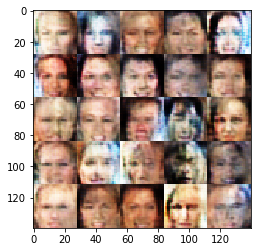

Epoch 1/1... Step 1205... Discriminator Loss: 1.5262... Generator Loss: 0.5019
Epoch 1/1... Step 1210... Discriminator Loss: 1.2369... Generator Loss: 0.8269
Epoch 1/1... Step 1215... Discriminator Loss: 1.2551... Generator Loss: 0.8560
Epoch 1/1... Step 1220... Discriminator Loss: 1.2624... Generator Loss: 0.8522
Epoch 1/1... Step 1225... Discriminator Loss: 1.3054... Generator Loss: 0.9725
Epoch 1/1... Step 1230... Discriminator Loss: 1.3805... Generator Loss: 0.6693
Epoch 1/1... Step 1235... Discriminator Loss: 1.4482... Generator Loss: 1.0418
Epoch 1/1... Step 1240... Discriminator Loss: 1.4332... Generator Loss: 0.4561
Epoch 1/1... Step 1245... Discriminator Loss: 1.2547... Generator Loss: 0.7161
Epoch 1/1... Step 1250... Discriminator Loss: 1.2491... Generator Loss: 0.8291
Epoch 1/1... Step 1255... Discriminator Loss: 1.2634... Generator Loss: 0.9418
Epoch 1/1... Step 1260... Discriminator Loss: 1.6001... Generator Loss: 0.4342
Epoch 1/1... Step 1265... Discriminator Loss: 1.3193

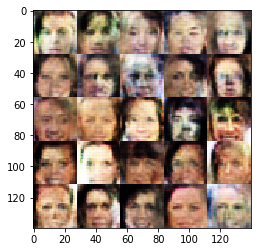

Epoch 1/1... Step 1305... Discriminator Loss: 1.0079... Generator Loss: 1.0075
Epoch 1/1... Step 1310... Discriminator Loss: 1.7331... Generator Loss: 0.4088
Epoch 1/1... Step 1315... Discriminator Loss: 1.3150... Generator Loss: 1.0131
Epoch 1/1... Step 1320... Discriminator Loss: 1.3027... Generator Loss: 1.0431
Epoch 1/1... Step 1325... Discriminator Loss: 1.2468... Generator Loss: 1.0632
Epoch 1/1... Step 1330... Discriminator Loss: 1.4720... Generator Loss: 1.4555
Epoch 1/1... Step 1335... Discriminator Loss: 1.2249... Generator Loss: 0.9352
Epoch 1/1... Step 1340... Discriminator Loss: 1.2119... Generator Loss: 0.9040
Epoch 1/1... Step 1345... Discriminator Loss: 1.2282... Generator Loss: 0.8858
Epoch 1/1... Step 1350... Discriminator Loss: 1.3590... Generator Loss: 0.7771
Epoch 1/1... Step 1355... Discriminator Loss: 1.2306... Generator Loss: 0.8372
Epoch 1/1... Step 1360... Discriminator Loss: 1.2826... Generator Loss: 0.8884
Epoch 1/1... Step 1365... Discriminator Loss: 1.2322

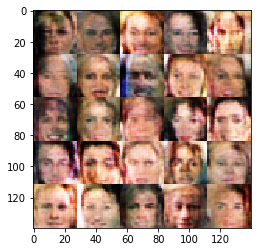

Epoch 1/1... Step 1405... Discriminator Loss: 1.1262... Generator Loss: 0.9024
Epoch 1/1... Step 1410... Discriminator Loss: 2.2175... Generator Loss: 0.1700
Epoch 1/1... Step 1415... Discriminator Loss: 1.3860... Generator Loss: 0.8921
Epoch 1/1... Step 1420... Discriminator Loss: 1.2530... Generator Loss: 0.7493
Epoch 1/1... Step 1425... Discriminator Loss: 1.4519... Generator Loss: 0.5605
Epoch 1/1... Step 1430... Discriminator Loss: 1.3870... Generator Loss: 0.5432
Epoch 1/1... Step 1435... Discriminator Loss: 1.1318... Generator Loss: 0.8310
Epoch 1/1... Step 1440... Discriminator Loss: 1.2823... Generator Loss: 0.6444
Epoch 1/1... Step 1445... Discriminator Loss: 1.1924... Generator Loss: 0.6808
Epoch 1/1... Step 1450... Discriminator Loss: 1.3813... Generator Loss: 0.6675
Epoch 1/1... Step 1455... Discriminator Loss: 1.1587... Generator Loss: 0.9453
Epoch 1/1... Step 1460... Discriminator Loss: 1.5129... Generator Loss: 0.7008
Epoch 1/1... Step 1465... Discriminator Loss: 1.1499

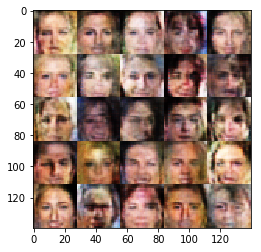

Epoch 1/1... Step 1505... Discriminator Loss: 1.3104... Generator Loss: 0.6512
Epoch 1/1... Step 1510... Discriminator Loss: 1.3134... Generator Loss: 0.5908
Epoch 1/1... Step 1515... Discriminator Loss: 1.2663... Generator Loss: 0.6893
Epoch 1/1... Step 1520... Discriminator Loss: 1.2894... Generator Loss: 0.6716
Epoch 1/1... Step 1525... Discriminator Loss: 1.2277... Generator Loss: 0.8676
Epoch 1/1... Step 1530... Discriminator Loss: 1.6794... Generator Loss: 0.4085
Epoch 1/1... Step 1535... Discriminator Loss: 1.1758... Generator Loss: 1.1048
Epoch 1/1... Step 1540... Discriminator Loss: 1.1236... Generator Loss: 1.5238
Epoch 1/1... Step 1545... Discriminator Loss: 1.1874... Generator Loss: 0.9493
Epoch 1/1... Step 1550... Discriminator Loss: 1.1587... Generator Loss: 0.7248
Epoch 1/1... Step 1555... Discriminator Loss: 1.2792... Generator Loss: 0.8916
Epoch 1/1... Step 1560... Discriminator Loss: 1.2900... Generator Loss: 0.5871
Epoch 1/1... Step 1565... Discriminator Loss: 1.4845

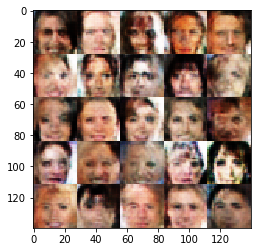

Epoch 1/1... Step 1605... Discriminator Loss: 1.3419... Generator Loss: 0.4781
Epoch 1/1... Step 1610... Discriminator Loss: 1.3190... Generator Loss: 0.6312
Epoch 1/1... Step 1615... Discriminator Loss: 1.3936... Generator Loss: 0.6064
Epoch 1/1... Step 1620... Discriminator Loss: 1.1549... Generator Loss: 0.9240
Epoch 1/1... Step 1625... Discriminator Loss: 1.2190... Generator Loss: 0.5875
Epoch 1/1... Step 1630... Discriminator Loss: 1.3754... Generator Loss: 0.6865
Epoch 1/1... Step 1635... Discriminator Loss: 1.4518... Generator Loss: 1.2958
Epoch 1/1... Step 1640... Discriminator Loss: 1.2432... Generator Loss: 0.7380
Epoch 1/1... Step 1645... Discriminator Loss: 1.2244... Generator Loss: 0.9863
Epoch 1/1... Step 1650... Discriminator Loss: 1.3950... Generator Loss: 0.7506
Epoch 1/1... Step 1655... Discriminator Loss: 1.4110... Generator Loss: 1.3679
Epoch 1/1... Step 1660... Discriminator Loss: 1.2685... Generator Loss: 0.6161
Epoch 1/1... Step 1665... Discriminator Loss: 1.5223

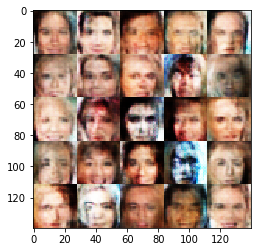

Epoch 1/1... Step 1705... Discriminator Loss: 1.2098... Generator Loss: 0.5551
Epoch 1/1... Step 1710... Discriminator Loss: 1.3706... Generator Loss: 0.7441
Epoch 1/1... Step 1715... Discriminator Loss: 1.5306... Generator Loss: 0.4059
Epoch 1/1... Step 1720... Discriminator Loss: 1.2105... Generator Loss: 0.6542
Epoch 1/1... Step 1725... Discriminator Loss: 1.4117... Generator Loss: 1.1384
Epoch 1/1... Step 1730... Discriminator Loss: 1.2828... Generator Loss: 0.9922
Epoch 1/1... Step 1735... Discriminator Loss: 1.3133... Generator Loss: 0.7140
Epoch 1/1... Step 1740... Discriminator Loss: 1.1449... Generator Loss: 0.8594
Epoch 1/1... Step 1745... Discriminator Loss: 1.3769... Generator Loss: 0.5566
Epoch 1/1... Step 1750... Discriminator Loss: 1.2026... Generator Loss: 0.7672
Epoch 1/1... Step 1755... Discriminator Loss: 1.3841... Generator Loss: 0.8253
Epoch 1/1... Step 1760... Discriminator Loss: 1.2256... Generator Loss: 0.7793
Epoch 1/1... Step 1765... Discriminator Loss: 1.3996

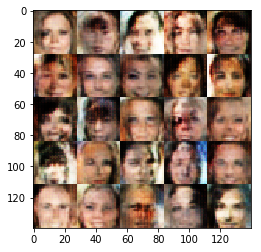

Epoch 1/1... Step 1805... Discriminator Loss: 1.3943... Generator Loss: 0.8503
Epoch 1/1... Step 1810... Discriminator Loss: 1.2592... Generator Loss: 0.7049
Epoch 1/1... Step 1815... Discriminator Loss: 1.4214... Generator Loss: 0.5317
Epoch 1/1... Step 1820... Discriminator Loss: 1.2257... Generator Loss: 0.9660
Epoch 1/1... Step 1825... Discriminator Loss: 1.2381... Generator Loss: 1.2213
Epoch 1/1... Step 1830... Discriminator Loss: 1.1620... Generator Loss: 1.0499
Epoch 1/1... Step 1835... Discriminator Loss: 1.3634... Generator Loss: 0.5961
Epoch 1/1... Step 1840... Discriminator Loss: 1.2499... Generator Loss: 1.1581
Epoch 1/1... Step 1845... Discriminator Loss: 1.2268... Generator Loss: 0.6466
Epoch 1/1... Step 1850... Discriminator Loss: 1.1137... Generator Loss: 1.0408
Epoch 1/1... Step 1855... Discriminator Loss: 1.3691... Generator Loss: 0.5467
Epoch 1/1... Step 1860... Discriminator Loss: 1.2294... Generator Loss: 1.1030
Epoch 1/1... Step 1865... Discriminator Loss: 1.2490

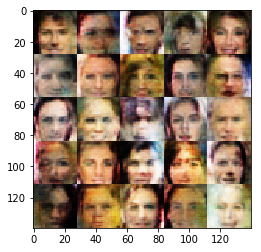

Epoch 1/1... Step 1905... Discriminator Loss: 1.4725... Generator Loss: 0.4654
Epoch 1/1... Step 1910... Discriminator Loss: 1.3235... Generator Loss: 0.6957
Epoch 1/1... Step 1915... Discriminator Loss: 1.3071... Generator Loss: 0.6414
Epoch 1/1... Step 1920... Discriminator Loss: 1.3361... Generator Loss: 0.4856
Epoch 1/1... Step 1925... Discriminator Loss: 1.2534... Generator Loss: 0.6991
Epoch 1/1... Step 1930... Discriminator Loss: 1.6329... Generator Loss: 0.3991
Epoch 1/1... Step 1935... Discriminator Loss: 1.4147... Generator Loss: 0.8550
Epoch 1/1... Step 1940... Discriminator Loss: 1.1810... Generator Loss: 1.0038
Epoch 1/1... Step 1945... Discriminator Loss: 1.1714... Generator Loss: 1.0331
Epoch 1/1... Step 1950... Discriminator Loss: 1.3564... Generator Loss: 1.1175
Epoch 1/1... Step 1955... Discriminator Loss: 1.1953... Generator Loss: 0.8163
Epoch 1/1... Step 1960... Discriminator Loss: 1.3241... Generator Loss: 0.6800
Epoch 1/1... Step 1965... Discriminator Loss: 1.3746

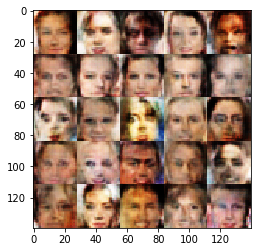

Epoch 1/1... Step 2005... Discriminator Loss: 1.2762... Generator Loss: 0.6591
Epoch 1/1... Step 2010... Discriminator Loss: 1.1399... Generator Loss: 0.9692
Epoch 1/1... Step 2015... Discriminator Loss: 1.3909... Generator Loss: 1.0482
Epoch 1/1... Step 2020... Discriminator Loss: 1.1769... Generator Loss: 0.7482
Epoch 1/1... Step 2025... Discriminator Loss: 1.2169... Generator Loss: 0.6147
Epoch 1/1... Step 2030... Discriminator Loss: 1.2992... Generator Loss: 1.0211
Epoch 1/1... Step 2035... Discriminator Loss: 1.2981... Generator Loss: 0.7904
Epoch 1/1... Step 2040... Discriminator Loss: 1.2425... Generator Loss: 0.8743
Epoch 1/1... Step 2045... Discriminator Loss: 1.3267... Generator Loss: 0.7933
Epoch 1/1... Step 2050... Discriminator Loss: 1.2963... Generator Loss: 0.7670
Epoch 1/1... Step 2055... Discriminator Loss: 1.7998... Generator Loss: 1.7124
Epoch 1/1... Step 2060... Discriminator Loss: 1.1508... Generator Loss: 1.0609
Epoch 1/1... Step 2065... Discriminator Loss: 1.3345

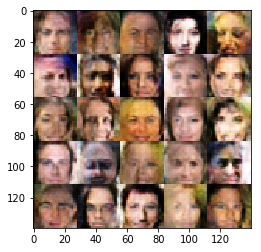

Epoch 1/1... Step 2105... Discriminator Loss: 1.3142... Generator Loss: 0.7469
Epoch 1/1... Step 2110... Discriminator Loss: 1.2989... Generator Loss: 0.6275
Epoch 1/1... Step 2115... Discriminator Loss: 1.2927... Generator Loss: 0.7745
Epoch 1/1... Step 2120... Discriminator Loss: 1.3073... Generator Loss: 1.0792
Epoch 1/1... Step 2125... Discriminator Loss: 1.1749... Generator Loss: 0.9153
Epoch 1/1... Step 2130... Discriminator Loss: 1.1472... Generator Loss: 0.8802
Epoch 1/1... Step 2135... Discriminator Loss: 1.2924... Generator Loss: 0.9148
Epoch 1/1... Step 2140... Discriminator Loss: 1.2598... Generator Loss: 0.7761
Epoch 1/1... Step 2145... Discriminator Loss: 1.2051... Generator Loss: 0.7572
Epoch 1/1... Step 2150... Discriminator Loss: 1.2227... Generator Loss: 0.6368
Epoch 1/1... Step 2155... Discriminator Loss: 1.2641... Generator Loss: 0.7317
Epoch 1/1... Step 2160... Discriminator Loss: 1.4270... Generator Loss: 1.0935
Epoch 1/1... Step 2165... Discriminator Loss: 1.2260

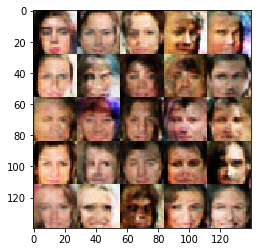

Epoch 1/1... Step 2205... Discriminator Loss: 1.2941... Generator Loss: 0.7946
Epoch 1/1... Step 2210... Discriminator Loss: 1.2737... Generator Loss: 0.6939
Epoch 1/1... Step 2215... Discriminator Loss: 1.3387... Generator Loss: 0.6706
Epoch 1/1... Step 2220... Discriminator Loss: 1.4681... Generator Loss: 0.9773
Epoch 1/1... Step 2225... Discriminator Loss: 1.4383... Generator Loss: 1.3814
Epoch 1/1... Step 2230... Discriminator Loss: 1.2604... Generator Loss: 0.9714
Epoch 1/1... Step 2235... Discriminator Loss: 1.2979... Generator Loss: 0.5850
Epoch 1/1... Step 2240... Discriminator Loss: 1.1825... Generator Loss: 1.1000
Epoch 1/1... Step 2245... Discriminator Loss: 1.2976... Generator Loss: 0.8868
Epoch 1/1... Step 2250... Discriminator Loss: 1.3175... Generator Loss: 0.8284
Epoch 1/1... Step 2255... Discriminator Loss: 1.2103... Generator Loss: 1.1505
Epoch 1/1... Step 2260... Discriminator Loss: 1.2272... Generator Loss: 0.7066
Epoch 1/1... Step 2265... Discriminator Loss: 1.3224

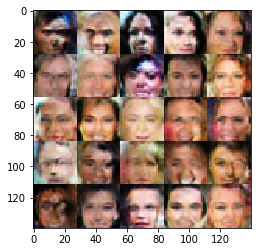

Epoch 1/1... Step 2305... Discriminator Loss: 1.2525... Generator Loss: 0.8561
Epoch 1/1... Step 2310... Discriminator Loss: 1.3415... Generator Loss: 1.1887
Epoch 1/1... Step 2315... Discriminator Loss: 1.3520... Generator Loss: 0.9168
Epoch 1/1... Step 2320... Discriminator Loss: 1.2674... Generator Loss: 0.6468
Epoch 1/1... Step 2325... Discriminator Loss: 1.0902... Generator Loss: 0.7002
Epoch 1/1... Step 2330... Discriminator Loss: 1.2545... Generator Loss: 0.9335
Epoch 1/1... Step 2335... Discriminator Loss: 1.4085... Generator Loss: 0.4903
Epoch 1/1... Step 2340... Discriminator Loss: 1.1970... Generator Loss: 0.5823
Epoch 1/1... Step 2345... Discriminator Loss: 1.5375... Generator Loss: 0.6448
Epoch 1/1... Step 2350... Discriminator Loss: 1.1278... Generator Loss: 0.9376
Epoch 1/1... Step 2355... Discriminator Loss: 1.5091... Generator Loss: 0.4963
Epoch 1/1... Step 2360... Discriminator Loss: 1.2735... Generator Loss: 0.8451
Epoch 1/1... Step 2365... Discriminator Loss: 1.0874

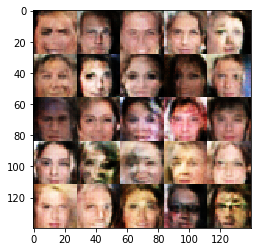

Epoch 1/1... Step 2405... Discriminator Loss: 1.3129... Generator Loss: 0.6857
Epoch 1/1... Step 2410... Discriminator Loss: 1.2424... Generator Loss: 0.7839
Epoch 1/1... Step 2415... Discriminator Loss: 1.2673... Generator Loss: 0.5705
Epoch 1/1... Step 2420... Discriminator Loss: 1.2412... Generator Loss: 0.7332
Epoch 1/1... Step 2425... Discriminator Loss: 1.1825... Generator Loss: 0.7959
Epoch 1/1... Step 2430... Discriminator Loss: 1.1387... Generator Loss: 0.8434
Epoch 1/1... Step 2435... Discriminator Loss: 1.3113... Generator Loss: 0.5666
Epoch 1/1... Step 2440... Discriminator Loss: 1.2205... Generator Loss: 0.7946
Epoch 1/1... Step 2445... Discriminator Loss: 1.1743... Generator Loss: 0.9859
Epoch 1/1... Step 2450... Discriminator Loss: 1.2384... Generator Loss: 0.9280
Epoch 1/1... Step 2455... Discriminator Loss: 1.2547... Generator Loss: 0.6102
Epoch 1/1... Step 2460... Discriminator Loss: 1.1964... Generator Loss: 0.7337
Epoch 1/1... Step 2465... Discriminator Loss: 1.3154

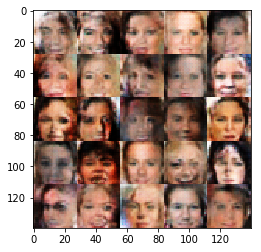

Epoch 1/1... Step 2505... Discriminator Loss: 1.3461... Generator Loss: 0.8269
Epoch 1/1... Step 2510... Discriminator Loss: 1.1367... Generator Loss: 0.8113
Epoch 1/1... Step 2515... Discriminator Loss: 1.3324... Generator Loss: 0.4880
Epoch 1/1... Step 2520... Discriminator Loss: 1.2882... Generator Loss: 0.7921
Epoch 1/1... Step 2525... Discriminator Loss: 1.3667... Generator Loss: 0.4554
Epoch 1/1... Step 2530... Discriminator Loss: 1.3459... Generator Loss: 0.8105
Epoch 1/1... Step 2535... Discriminator Loss: 1.4254... Generator Loss: 0.5802
Epoch 1/1... Step 2540... Discriminator Loss: 1.1528... Generator Loss: 0.6933
Epoch 1/1... Step 2545... Discriminator Loss: 1.2652... Generator Loss: 0.6559
Epoch 1/1... Step 2550... Discriminator Loss: 1.2700... Generator Loss: 0.7844
Epoch 1/1... Step 2555... Discriminator Loss: 1.1838... Generator Loss: 0.6544
Epoch 1/1... Step 2560... Discriminator Loss: 1.3345... Generator Loss: 0.5658
Epoch 1/1... Step 2565... Discriminator Loss: 1.1221

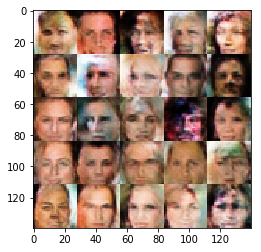

Epoch 1/1... Step 2605... Discriminator Loss: 1.3223... Generator Loss: 1.1995
Epoch 1/1... Step 2610... Discriminator Loss: 1.3201... Generator Loss: 0.9982
Epoch 1/1... Step 2615... Discriminator Loss: 1.2573... Generator Loss: 0.5983
Epoch 1/1... Step 2620... Discriminator Loss: 1.2162... Generator Loss: 0.8560
Epoch 1/1... Step 2625... Discriminator Loss: 1.3044... Generator Loss: 0.7793
Epoch 1/1... Step 2630... Discriminator Loss: 1.2577... Generator Loss: 0.7617
Epoch 1/1... Step 2635... Discriminator Loss: 1.1883... Generator Loss: 1.1369
Epoch 1/1... Step 2640... Discriminator Loss: 1.2264... Generator Loss: 1.1013
Epoch 1/1... Step 2645... Discriminator Loss: 1.3132... Generator Loss: 0.5584
Epoch 1/1... Step 2650... Discriminator Loss: 1.3530... Generator Loss: 0.8667
Epoch 1/1... Step 2655... Discriminator Loss: 1.2246... Generator Loss: 0.8355
Epoch 1/1... Step 2660... Discriminator Loss: 1.2912... Generator Loss: 0.8183
Epoch 1/1... Step 2665... Discriminator Loss: 1.3280

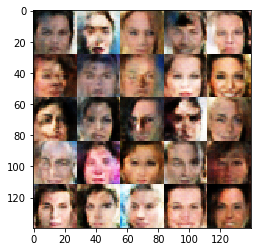

Epoch 1/1... Step 2705... Discriminator Loss: 1.2506... Generator Loss: 0.8510
Epoch 1/1... Step 2710... Discriminator Loss: 1.0413... Generator Loss: 0.9083
Epoch 1/1... Step 2715... Discriminator Loss: 1.4400... Generator Loss: 0.9910
Epoch 1/1... Step 2720... Discriminator Loss: 1.1915... Generator Loss: 1.0569
Epoch 1/1... Step 2725... Discriminator Loss: 1.4539... Generator Loss: 0.4239
Epoch 1/1... Step 2730... Discriminator Loss: 1.1613... Generator Loss: 0.6192
Epoch 1/1... Step 2735... Discriminator Loss: 1.3254... Generator Loss: 1.1705
Epoch 1/1... Step 2740... Discriminator Loss: 1.2069... Generator Loss: 0.6235
Epoch 1/1... Step 2745... Discriminator Loss: 1.3267... Generator Loss: 0.5531
Epoch 1/1... Step 2750... Discriminator Loss: 1.3806... Generator Loss: 0.4962
Epoch 1/1... Step 2755... Discriminator Loss: 1.3818... Generator Loss: 0.7506
Epoch 1/1... Step 2760... Discriminator Loss: 1.3359... Generator Loss: 0.6720
Epoch 1/1... Step 2765... Discriminator Loss: 1.3655

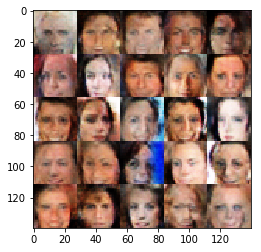

Epoch 1/1... Step 2805... Discriminator Loss: 1.2176... Generator Loss: 0.9206


In [ ]:
batch_size = 64
z_dim = 100#512
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.